In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import matplotlib.pyplot as plt
import netket as nk
import jax.numpy as jnp

import flax
import flax.linen as nn

import plot_utils
import seaborn as sns

# set pallette to pastel 

sns.set_palette("pastel")



### Define the Hamiltonian

In [2]:
N = 2
def v(x):

    return 0.5*jnp.linalg.norm(x) ** 2

def minimum_distance(x, sdim): # sdim is the spatial dimension
    """Computes distances between particles using mimimum image convention"""
    n_particles = x.shape[0] // sdim
    x = x.reshape(-1, sdim)

    distances = (-x[jnp.newaxis, :, :] + x[:, jnp.newaxis, :])[
                    jnp.triu_indices(n_particles, 1)
                ]

    return jnp.linalg.norm(distances, axis=1)
                
def interaction(x, sdim):
    """Computes the potential energy of the system"""
    dis = minimum_distance(x, sdim)

    return jnp.sum(1/dis)

# Define the hilbert space

In [3]:
hilb = nk.hilbert.Particle(N=N, L=(jnp.inf,jnp.inf), pbc=False) # L = dimension, pcb is 


In [4]:

ekin = nk.operator.KineticEnergy(hilb, mass=1.0)

pot = nk.operator.PotentialEnergy(hilb, v)

interact = nk.operator.PotentialEnergy(hilb, lambda x: interaction(x, 2))

ha = ekin + pot #+ interact

In [5]:
class FFN(nn.Module):

    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole
    # flax module. This is the ratio of neurons to input dofs
    alpha: int = 1

    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        dense = nn.Dense(features=self.alpha * x.shape[-1], param_dtype=float)

        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)

        # sum the output
        return jnp.sum(y, axis=-1)

### Define the sampler

In [58]:
sampler_gaussian = nk.sampler.MetropolisGaussian(hilb, sigma=1, n_chains=16, n_sweeps=32) # sigma is the standard deviation of the gaussian that is used to sample the configuration space

sampler_rbm = nk.sampler.MetropolisGaussian(hilb, sigma=1e-4, n_chains=16, n_sweeps=16)

sampler_FFN = nk.sampler.MetropolisGaussian(hilb,  sigma=1, n_chains=16, n_sweeps=32)


### Models

In [111]:
model_gaussian = nk.models.Gaussian()
vs_gaussian = nk.vqs.MCState(sampler_gaussian, model_gaussian, n_samples=10 ** 4, n_discard_per_chain=2000)

model_rbm = nk.models.RBM(alpha=2)
vs_rbm = nk.vqs.MCState(sampler_rbm, model_rbm, n_samples=10 ** 4, n_discard_per_chain=2000)

model_ffn = FFN(alpha=2)
vs_ffn = nk.vqs.MCState(sampler_FFN, model_ffn, n_samples=2**14, n_discard_per_chain=2000)

#optimizer
op_gaussian = nk.optimizer.Sgd(learning_rate=0.01)
op_rbm = nk.optimizer.Sgd(learning_rate=1e-3)
op_ffn = nk.optimizer.Sgd(learning_rate=0.01)

#Preconditioner
sr_gaussian = nk.optimizer.SR(diag_shift=0.01)
sr_rbm = nk.optimizer.SR(diag_shift=0.4)
sr_ffn = nk.optimizer.SR(diag_shift=0.01)

100%|██████████| 100/100 [00:18<00:00,  5.52it/s, Energy=2.034 ± 0.055 [σ²=1.544, R̂=1.4136]]


Text(0, 0.5, 'Energy')

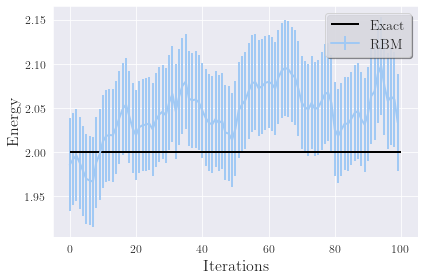

In [112]:
gs_gaussian = nk.VMC(ha, op_gaussian, sampler_gaussian, variational_state=vs_gaussian, preconditioner=sr_gaussian) # gs stands for ground state
gs_rbm = nk.VMC(ha, op_rbm, sampler_rbm, variational_state=vs_rbm, preconditioner=sr_rbm)
gs_ffn = nk.VMC(ha, op_ffn, sampler_FFN, variational_state=vs_ffn, preconditioner=sr_ffn)

iters = 100

# log=nk.logging.RuntimeLog()
# gs_gaussian.run(n_iter=iters,out=log)
#data_gaussian = log.data

#log=nk.logging.RuntimeLog()
#gs_rbm.run(n_iter=iters,out=log)
#data_rbm = log.data

log=nk.logging.RuntimeLog()
gs_ffn.run(n_iter=iters,out=log)
data_ffn = log.data

#sns.lineplot(data=data_gaussian["Energy"].iters, data=data_gaussian["Energy"].Mean, yerr=data_gaussian["Energy"].Sigma, label="Gaussian")
#sns.lineplot(data=data_rbm["Energy"].iters, data=data_rbm["Energy"].Mean, yerr=data_rbm["Energy"].Sigma, label="RBM")
#sns.lineplot(data=data_ffn["Energy"].iters, data=data_ffn["Energy"].Mean, yerr=data_ffn["Energy"].Sigma, label="FFN")


#plt.errorbar(data_gaussian["Energy"].iters, data_gaussian["Energy"].Mean, yerr=data_gaussian["Energy"].Sigma, label="Gaussian")
plt.errorbar(data_rbm["Energy"].iters, data_rbm["Energy"].Mean, yerr=data_rbm["Energy"].Sigma, label="RBM")
#plt.errorbar(data_ffn["Energy"].iters, data_ffn["Energy"].Mean, yerr=data_ffn["Energy"].Sigma, label="FFN")

# make background white
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# add grid
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

plt.hlines(2, xmin=0, xmax=iters, color='black', label="Exact")
plt.legend()

plt.xlabel('Iterations')
plt.ylabel('Energy')

In [19]:
data_rbm

{'Energy': History(
    keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], 
    iters = [0, 1, ... 198, 199] (200 steps),
 )}